# multiphase/interFoam/laminar/mixerVessel2D


In [2]:
%matplotlib inline
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import vtk
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


In [186]:
import os
files = os.listdir("mixerVessel2D/VTK")
for f in files[:12]:
    print(f)
    
print "--- Rotor ---"
files = os.listdir("mixerVessel2D/VTK/rotor")
for f in files[:12]:
    print(f)
    
print "--- Stator ---"
files = os.listdir("mixerVessel2D/VTK/stator")
for f in files[:12]:
    print(f)
    
print "--- Front ---"
files = os.listdir("mixerVessel2D/VTK/front")
for f in files[:12]:
    print(f)

back
front
mixerVessel2D_0.vtk
mixerVessel2D_101.vtk
mixerVessel2D_117.vtk
mixerVessel2D_133.vtk
mixerVessel2D_149.vtk
mixerVessel2D_164.vtk
mixerVessel2D_179.vtk
mixerVessel2D_194.vtk
mixerVessel2D_209.vtk
mixerVessel2D_224.vtk
--- Rotor ---
rotor_0.vtk
rotor_101.vtk
rotor_117.vtk
rotor_133.vtk
rotor_149.vtk
rotor_164.vtk
rotor_179.vtk
rotor_194.vtk
rotor_209.vtk
rotor_224.vtk
rotor_238.vtk
rotor_251.vtk
--- Stator ---
stator_0.vtk
stator_101.vtk
stator_117.vtk
stator_133.vtk
stator_149.vtk
stator_164.vtk
stator_179.vtk
stator_194.vtk
stator_209.vtk
stator_224.vtk
stator_238.vtk
stator_251.vtk
--- Front ---
front_0.vtk
front_101.vtk
front_117.vtk
front_133.vtk
front_149.vtk
front_164.vtk
front_179.vtk
front_194.vtk
front_209.vtk
front_224.vtk
front_238.vtk
front_251.vtk


In [202]:
def getData(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    vtk_arrays= reader.GetOutput().GetPointData()
    #print vtk_nodes
    #print vtk_arrays
    return vtk_arrays

def getNodes(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    points = reader.GetOutput().GetPoints()
    if points is None:
        return None
#    print points
#    Get the coordinates of nodes in the mesh
    nodes_vtk_array= reader.GetOutput().GetPoints().GetData()  
    nodes = vtk_to_numpy(nodes_vtk_array)
    return nodes

In [223]:
# Remove data for z != 0
def extractFlatData(nodes, a, U):
    merged = np.empty([len(nodes),6])
    merged[:,0] = a
    merged[:,1:3] = U[:,:2]
    merged[:,3:] = nodes
    # Merged z0 and z1 arrays should be same because of 
    # the model symmetry along z-axis
    merged_z0 = merged[np.where(merged[:,5] == 0)]
    merged_z1 = merged[np.where(merged[:,5] != 0)]
    # Extract nodes, p and U arrays from z0 array
    a = merged_z0[:,0]
    U = merged_z0[:,1:3]
    nodes = merged_z0[:,3:5]
    return nodes, a, U

# Remove data for |U| == 0 and z != 0
def extractNonzeroData(nodes, a, U):
    merged = np.empty([len(nodes),7])
    print "Extrcting |U|!=0.\na:{} U:{} nodes:{}".format(a.shape, U.shape, nodes.shape)
    merged[:,0] = a
    merged[:,1:3] = U[:,:2]
    merged[:,3:6] = nodes
    # U length squared ^2
    merged[:, 6] = np.power(U[:,0],2) + np.power(U[:,1],2)
    merged_nonzero = merged[np.where(merged[:,6] > 0.01)]
    merged_nonzero = merged_nonzero[np.where(merged_nonzero[:,5] == 0)]
    print "Nonzero matrix shape: {}".format(merged_nonzero.shape)
    # Extract nodes, p and U arrays from z0 array
    a = merged_nonzero[:,0]
    U = merged_nonzero[:,1:3]
    nodes = merged_nonzero[:,3:5]
    return nodes, a, U


In [226]:
# Plot vector field on existing figure
def plotVector_combined(nodes, U, vmin, vmax, filename=""):
    X = nodes[:,0]
    Y = nodes[:,1]
    UN = U[:,0]
    VN = U[:,1]
    stride_elmts = 5
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data                
               np.hypot(UNsub, VNsub),
 #              Usub,                   # colour the arrows based on this array
 #              color='#ffee77',
               cmap=plt.cm.YlOrRd,
               norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax), # Colour range fix
               linewidth=0.5,
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    
# Plot 2D data on existing figure
def plot2D_combined(nodes, a, vmin, vmax):     
    cmap = mpl.cm.seismic
    color_map = plt.cm.get_cmap('GnBu')
    sc = plt.scatter(nodes[:,0],nodes[:,1],
                     s=550,
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="o")
#    plt.colorbar(sc)
 

0.0 - 1.0
(6528,)
Extrcting |U|!=0.
a:(6528,) U:(6528, 3) nodes:(6528, 3)
Nonzero matrix shape: (1527, 7)


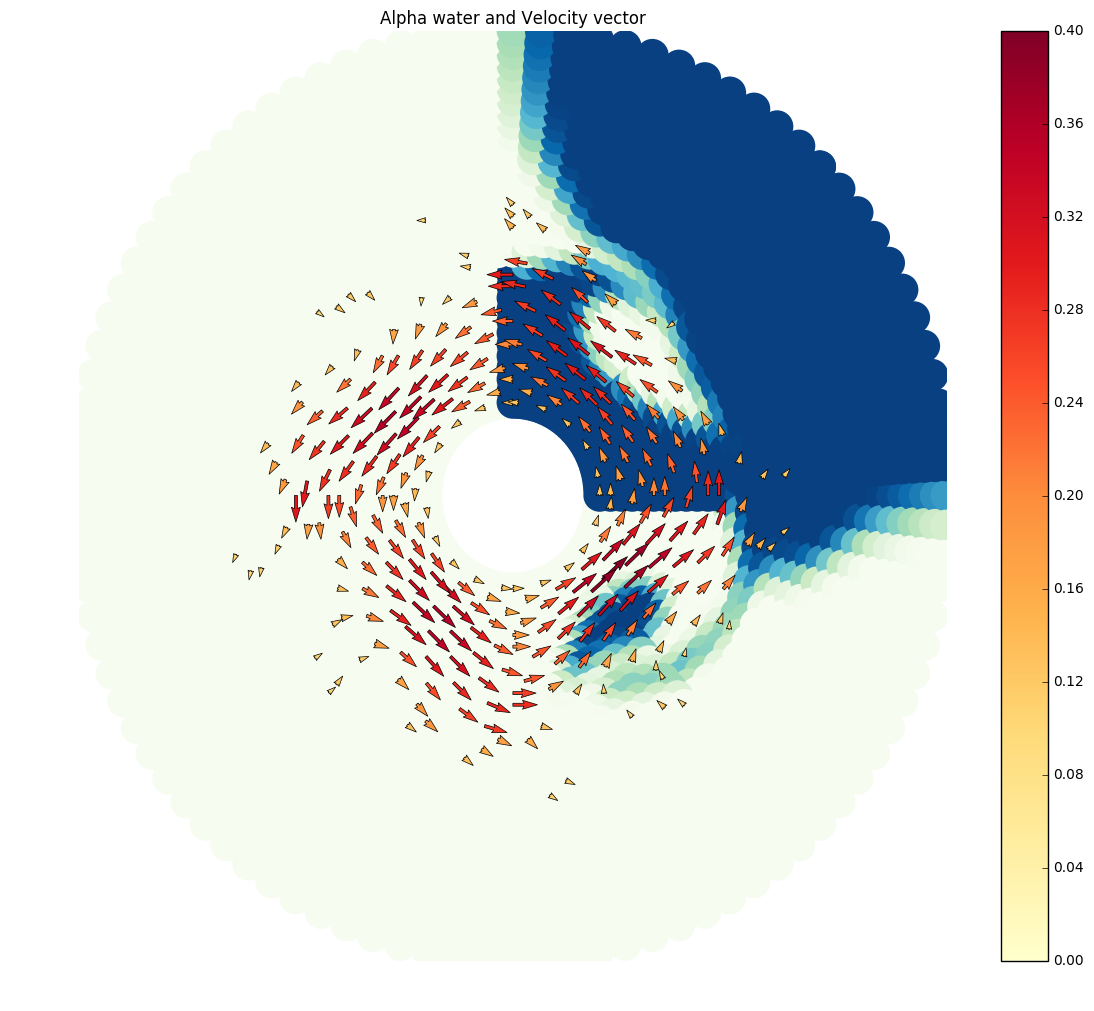

In [227]:
filename = "mixerVessel2D/VTK/mixerVessel2D_101.vtk"
#nodes, p , U   = getData_pvm(filename)
vtk_data = getData(filename)
nodes = getNodes(filename)
p = vtk_to_numpy(vtk_data.GetArray(0))
alpha = vtk_to_numpy(vtk_data.GetArray(1))
p_rgh = vtk_to_numpy(vtk_data.GetArray(2))
U = vtk_to_numpy(vtk_data.GetArray(3))
a = alpha

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print a.shape

nodes_half, a_half, U_half = extractFlatData(nodes, a, U)
nodes_nonzero, a_nonzero, U_nonzero = extractNonzeroData(nodes, a, U)
# Plot combined figure
plt.figure(figsize=(14,12))
axes = plt.gca()
plt.axis([-.1, .1, -.1, .1])
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('off')

plt.title('Alpha water and Velocity vector')
plot2D_combined(nodes_half, a_half, vmin, vmax)
plotVector_combined(nodes_nonzero, U_nonzero, 0, 0.4)

plt.show()

0.0 - 1.0
(6528,)


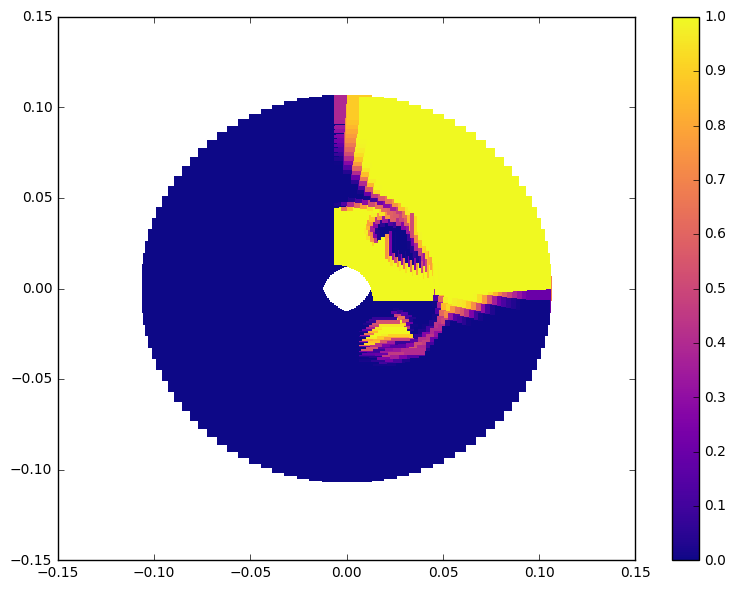

In [195]:
filename = "mixerVessel2D/VTK/mixerVessel2D_101.vtk"
vtk_data = getData(filename)
nodes = getNodes(filename)
alpha = vtk_to_numpy(vtk_data.GetArray(1))
U = vtk_to_numpy(vtk_data.GetArray(3))
nodes, a, U = extractFlatData(nodes,alpha,U)

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print alpha.shape

plot2D(nodes, a, vmin, vmax)


In [204]:
filename = "mixerVessel2D/VTK/rotor/rotor_101.vtk"
vtk_data = getData(filename)
print vtk_data

nodes = getNodes(filename)
print nodes
alpha = vtk_to_numpy(vtk_data.GetArray(1))
U = vtk_to_numpy(vtk_data.GetArray(3))
nodes, a, U = extractFlatData(nodes,alpha,U)

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print alpha.shape

plot2D(nodes, a, vmin, vmax)



vtkPointData (0x6d06d80)
  Debug: Off
  Modified Time: 37816
  Reference Count: 1
  Registered Events: (none)
  Number Of Arrays: 0
  Number Of Components: 0
  Number Of Tuples: 0
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)


None


AttributeError: 'NoneType' object has no attribute 'GetDataType'

In [42]:
def plotVector(X, Y, UN, VN, U, vmin, vmax, filename=""):
    plot1 = plt.figure(figsize=(14,10))
    print U.shape
    stride_elmts = 10
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    Usub = U[::stride_elmts]
    print Usub.shape
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data
               Usub,                   # colour the arrows based on this array
               #cmap=plt.cm.plasma,     # colour map
               norm=mpl.colors.Normalize(vmin=0,vmax=1), # Colour range fix
               
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity vector')
    if (filename != ""):
        plot1.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show(plot1)                 # display the plot
    plt.close(plot1)

In [43]:
def plotCombined(X, Y, UN, VN, U, vmin, vmax, a, filename=""):
    plot1 = plt.figure(figsize=(14,10))
    
    print a.shape    
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-.1,2.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(X,Y,
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    #fig.tight_layout()
    print U.shape
    stride_elmts = 10
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    Usub = U[::stride_elmts]
    print Usub.shape
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data
               Usub,                   # colour the arrows based on this array
               #cmap=plt.cm.plasma,     # colour map
               norm=mpl.colors.Normalize(vmin=0,vmax=1), # Colour range fix               
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity vector')
    
    
    
    if (filename != ""):
        plot1.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show(plot1)                 # display the plot
    plt.close(plot1)



(0.10040204915044618, 0.39231571849367608)
(3054,)
(306,)


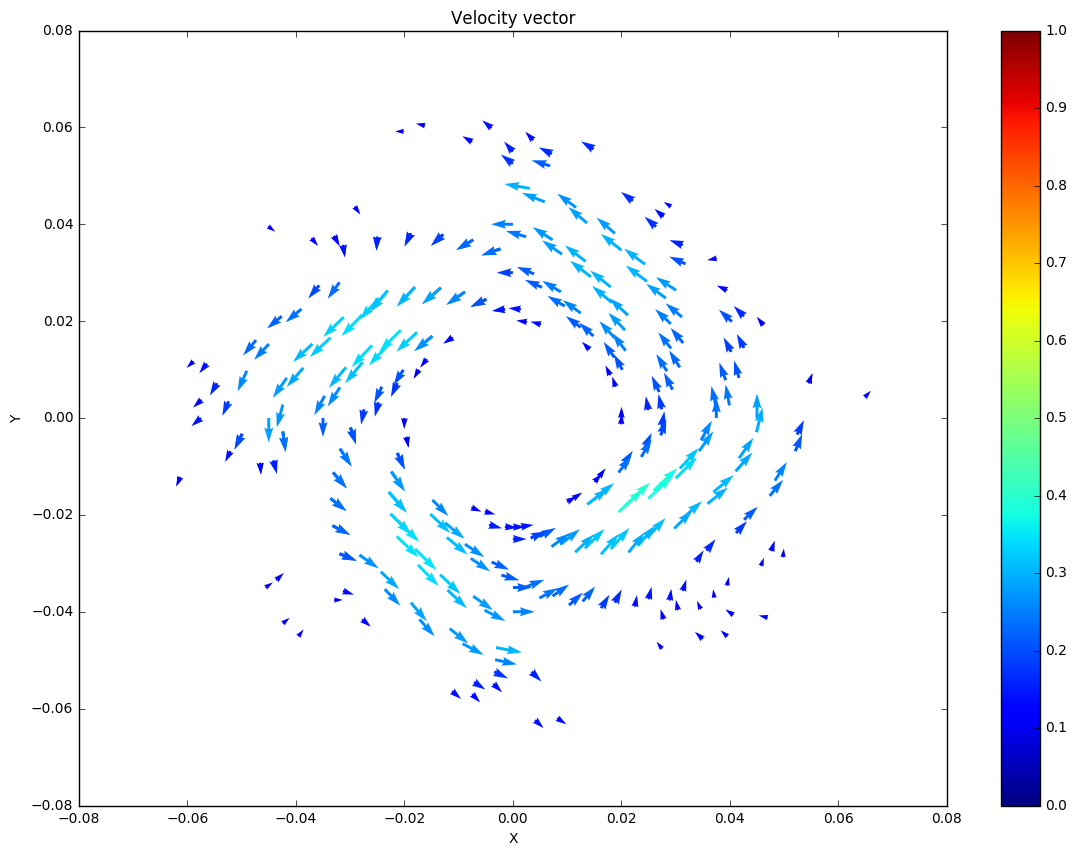

In [215]:
if a_nonzero.size > 0:
    Un_nonzero = np.sqrt(U_nonzero[:,0]**2 + U_nonzero[:,1]**2) #Randomisation:  + np.random.rand(U_half.shape[0])
    print(np.amin(Un_nonzero),np.amax(Un_nonzero))
    plotVector(nodes_nonzero[:,0], nodes_nonzero[:,1], U_nonzero[:,0], U_nonzero[:,1], 
               Un_nonzero, np.amin(Un_nonzero), np.amax(Un_nonzero))

Un half: 0.0 - 0.368021271409
[  0.00000000e+00   5.93944995e-37   4.16211010e-35 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
(3264,)
(3264,)
(327,)


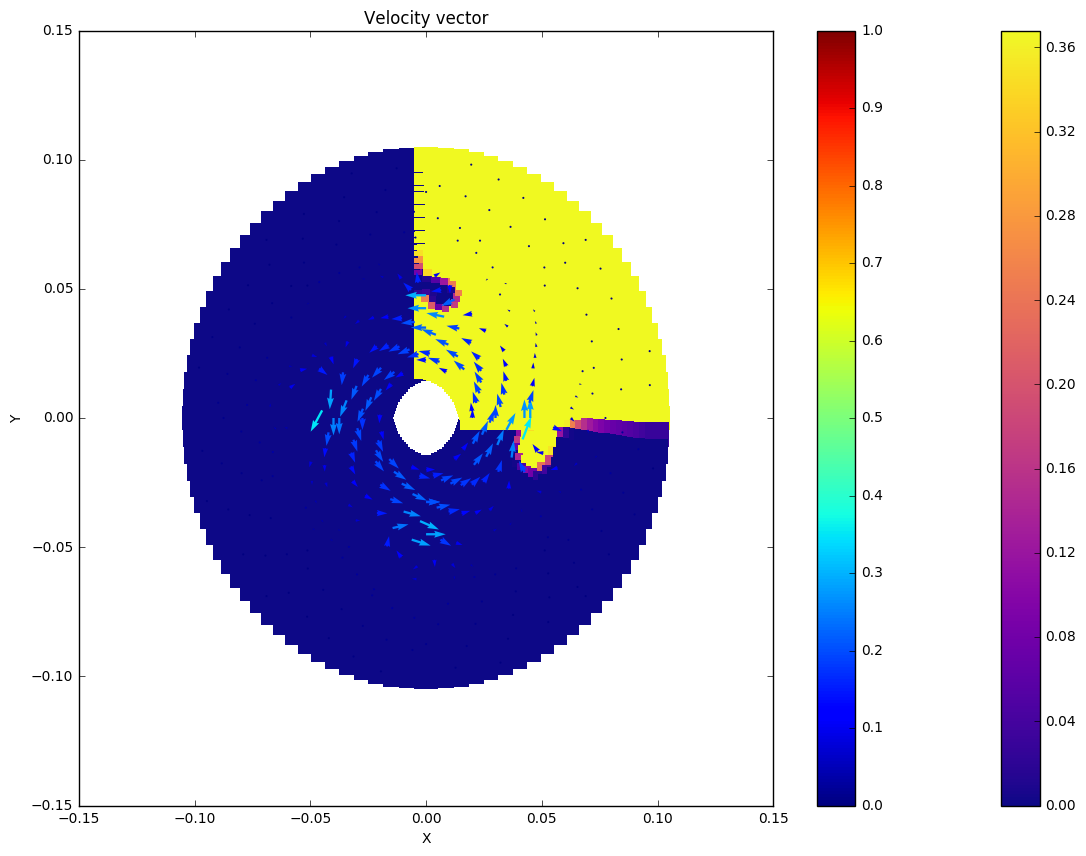

In [51]:
Un_half = np.sqrt(U_half[:,0]**2 + U_half[:,1]**2) #Randomisation:  + np.random.rand(U_half.shape[0])
print"Un half: {} - {}".format(np.amin(Un_half),np.amax(Un_half))
print a
plotCombined(nodes_half[:,0], nodes_half[:,1], U_half[:,0], U_half[:,1], 
               Un_half, np.amin(Un_half), np.amax(Un_half), a_half)

In [159]:
def plot2D(nodes, a, vmin, vmax):     
    # 2d plotting
    fig = plt.figure(figsize=(8,6))
    cmap = mpl.cm.seismic
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-.1,2.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(nodes[:,0],nodes[:,1],
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    fig.tight_layout()

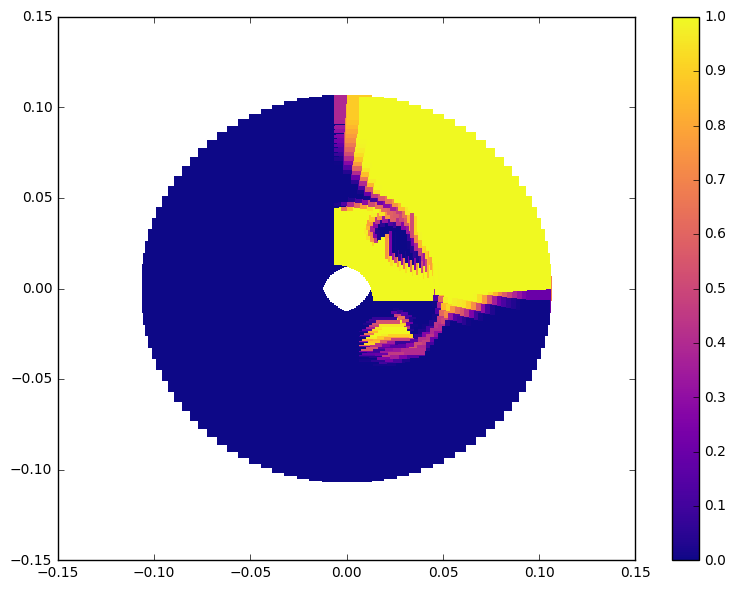

In [160]:

plot2D(nodes_half,a_half, vmin, vmax)

In [178]:
def plot3D(nodes, a, vmin=0, vmax=0):
    print"Shapes: {} {} {}".format(nodes[:,0].shape, nodes[:,1].shape, a.shape)
    color_map = plt.cm.get_cmap('plasma')
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    if vmax==0 and vmin==0:
        vmin = np.amin(a)
        vmax = np.amax(a)
    axes = plt.gca()
    axes.set_xlim([-.07,.07])
    axes.set_ylim([-.07,.07])
    axes.set_zlim([-.06,.06])
    splt = ax.scatter(nodes[:,0],nodes[:,1],nodes[:,2],
                      s = 100,
                      c = a,
                      cmap = color_map,
                      vmin = vmin,
                      vmax = vmax,
                      linewidth=0.1,
                      marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(splt, shrink=0.5)
    plt.show()